# Simple training example

Tomasz Szoldra, 2023

In [ ]:
!git clone https://github.com/tszoldra/attoDNN

In [ ]:
!pip install -e attoDNN

Training of the models is semi-automated through `train.py` script:

In [ ]:
!wget --no-check-certificate https://chaos.if.uj.edu.pl/ZOA/tree//2303.13940/data_preprocessed/Experiment/Experiment_Argon_Intensity_Sweep_04_cutoff.npz

In [ ]:
!wget --no-check-certificate https://chaos.if.uj.edu.pl/ZOA/tree//2303.13940/data_preprocessed/Qprop/QProp_Ar_small_sample.npz

In [4]:
# %load ../run/train.py
import sys
import os
from functools import partial
import numpy as np

import tensorflow as tf

from attoDNN.attodataset import AttoDataset
from attoDNN import nets, train_utils as tu, preprocess as pp, data_generator as dg
import datetime

if __name__ == "__main__":
    print(nets.list_GPUs())

    # tu.set_memory_growth()
    parser = tu.train_parser()
    args = parser.parse_args()

    # ============= CONFIGURATION ================
    model_save_folder = args.model_save_folder
    dataset_path = args.dataset_path

    datasets_extra_validation_paths = [
        'Experiment_Argon_Intensity_Sweep_04_cutoff.npz',
    ]
    ds_extra_val = [AttoDataset(fn) for fn in datasets_extra_validation_paths]

    # =========== preprocessing ===========

    feature = 'Up'

    preprocess_kwargs = {
        'threshold': 1e-6,
        'downsample_1': 1,
        'downsample_2': 1,
        'shape': (224, 224, 1)
    }

    def preprocessor(PDFs):
        return pp.preprocess_2(PDFs, **preprocess_kwargs) # see documentation how it preprocesses the data

    def preprocessor_validation(PDFs):
        return pp.preprocess_2(PDFs, **preprocess_kwargs)

    # =========== dataset split ===========

    train_test_split_kwargs = {
        'val_size': 0.1,
        'test_size': 0.1,
        'random_state': 1234,  #is always the same for train/test splitting
    }

    train_test_split = partial(tu.regression_train_test_split_4, **train_test_split_kwargs)


    def transform_X_fun(X):
        X = dg.random_detector_saturation_tf(X,
                                             saturation_level_min=args.saturation_level_min,
                                             saturation_level_max=args.saturation_level_max,
                                             )
        X = dg.random_flip_lrud_tf(X)
        X = dg.random_contrast_tf(X, contrast_min=0.1, contrast_max=1.0)
        X = dg.random_brightness_tf(X, brightness_max_delta=1.0)
        X = tf.clip_by_value(X, -1, 1)
        return X


    def transform_y_fun(y):
        return y


    data_gen_train = partial(dg.DataGenerator, transform_X_fun=transform_X_fun,
                             transform_y_fun=transform_y_fun,
                             batch_size=args.batch_size,
                             shuffle=True)
    data_gen_val = partial(dg.DataGenerator, transform_X_fun=None,
                           transform_y_fun=None,
                           batch_size=args.batch_size,
                           shuffle=True)
    data_gen_test = partial(dg.DataGenerator, transform_X_fun=None,
                            transform_y_fun=None,
                            batch_size=args.batch_size,
                            shuffle=True)

    # =========== training hyperparameters ============

    n_models = args.n_models

    model_funs = {
        args.model_name: partial(nets.deepCNN_pretrained_bayesian,
                          pretrained_model=getattr(tf.keras.applications, args.model_name) if 'ConvNeXt' not in args.model_name else getattr(tf.keras.applications.convnext, args.model_name),
                          dropout_rate=0.2,
                          weights='imagenet',
                          pooling='avg',
                          dense_layers=args.dense_layers,
                          )
    }

    lr_scheduler_kwargs = {
        'decay_rate': 0.5,
        'decay_step': 50
    }


    def callbacks(tensorboard_path):
        return [
            # PlotLossesKeras(),
            tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path,
                                           #histogram_freq=1,
                                           #profile_batch='50,70',
                                           write_images=True,
                                           #embeddings_freq=1,
                                           ),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),
            tf.keras.callbacks.LearningRateScheduler(tu.lr_scheduler(**lr_scheduler_kwargs)),
            *[tu.ExtraValidation(*(ds_val.get_Xy()), tensorboard_path + '/extra_validation', ds_val.basename)
              for ds_val in ds_extra_val],
        ]


    def optimizer():
        opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
        #tu.to_accumulative(opt, update_params_frequency=60)
        return opt


    def optimizer_fine_tune():
        opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
        #tu.to_accumulative(opt, update_params_frequency=60)
        return opt


    def kernel_regularizer():
        #return tf.keras.regularizers.L1L2(l1=1e-7, l2=1e-7)
        return None


    def loss():
        return tu.RegressionNLL()


    training_kwargs = {
        'epochs': 50,
        'epochs_fine_tune': 150,
        'optimizer': optimizer,
        'loss': loss,
        'callbacks': callbacks,
        'callbacks_fine_tune': callbacks,
        'checkpoint': True,
        'checkpoint_filename': args.checkpoint_filename,
        'fine_tune': True,
        'optimizer_fine_tune': optimizer_fine_tune,
        'kernel_regularizer': kernel_regularizer,
    }

    # Possible bug to avoid: callbacks(?), optimizer and loss objects cannot
    # be shared between model instances as they will connect graphs.
    # Then ValueError: Unable to create dataset (name already exists),

    # ============= END CONFIGURATION ================

    ds = AttoDataset(dataset_path)
    ds.preprocess(preprocessor, feature)


    for ds_val in ds_extra_val:
        ds_val.preprocess(preprocessor_validation, feature)

    for model_number in range(args.random_state, args.random_state + n_models):
        X_train, X_val, X_test, y_train, y_val, y_test = train_test_split(*ds.get_Xy(),
                                                                          random_state_validation=model_number)
        dg_train = data_gen_train(X_train, y_train)
        dg_val = data_gen_val(X_val, y_val)
        dg_test = data_gen_test(X_test, y_test)

        for model_name, model_fun in model_funs.items():
            training_kwargs['model_save_filename'] = f'{model_save_folder}/{ds.basename}_SL_{args.saturation_level_min}__Bayesian{model_name}__{model_number}.h5'
            training_kwargs['log_filename'] = model_save_folder + '/logs.txt'
            training_kwargs['callbacks'] = lambda: callbacks(training_kwargs['model_save_filename'][:-3])
            training_kwargs['callbacks_fine_tune'] = lambda: callbacks(
                tensorboard_path=training_kwargs['model_save_filename'][:-3] + '__fine_tune')

            model = tu.model_compile_train_save(dg_train, dg_val, dg_test,
                                                model_fun, **training_kwargs)
            print('GPU USAGE:')
            mem_info = tf.config.experimental.get_memory_info('GPU:0')
            print(f"current mem = {mem_info['current'] / 1073741824} GB")
            print(f"peak mem = {mem_info['peak'] / 1073741824} GB")
            tf.compat.v1.reset_default_graph()
            del model
            tf.keras.backend.clear_session()

        del X_train, X_test, X_val, y_train, y_val, y_test


In [7]:
# USAGE
!python ../run/train.py --help

/bin/bash: /home/c8888/usr_local_bin/anaconda3/envs/tf-keras-vis/lib/libtinfo.so.6: no version information available (required by /bin/bash)
2023-04-06 16:30:55.127405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 16:30:55.131968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 16:30:55.132143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
usage: train.py [-h] [--dense_layers DENSE_LAYERS [DENSE_LAYERS ...]]
                [--tensorboard_path TENSORBOARD_PATH]
        

For example, we will train BayesianVGG16 model (ie. regression VGG16 with two outputs - mean and variance) as an ensemble of 2 models on a small QProp dataset, SL=0.0, batch size 32, and save our models in the working directory:

This may take ~15 minutes.

In [ ]:
!python attoDNN/run/train.py ./ QProp_Ar_small_sample.npz 1000 2 VGG16 ./checkpoint 0.0 1.0 32

Now, let's evaluate the models on the following datasets:

In [ ]:
!echo "Experiment_Argon_Intensity_Sweep_01_cutoff.npz" >> eval_datasets.txt

In [ ]:
!echo "QProp_Ar_small_sample.npz" >> eval_datasets.txt

In [18]:
!python attoDNN/run/evaluate.py --help

/bin/bash: /home/c8888/usr_local_bin/anaconda3/envs/tf-keras-vis/lib/libtinfo.so.6: no version information available (required by /bin/bash)
usage: evaluate.py [-h] [--gpu] [--batch_size BATCH_SIZE] [--save_plot]
                   [--only_test] [--feature {Up,N,CEP}]
                   [--threshold THRESHOLD] [--remove_region_around_origin]
                   [--frac_x_remove FRAC_X_REMOVE]
                   [--frac_y_remove FRAC_Y_REMOVE] [--use_data_generator]
                   [--saturation_level_min SATURATION_LEVEL_MIN]
                   [--num_data_gen_realizations NUM_DATA_GEN_REALIZATIONS]
                   [--auto_saturation_level_min]
                   datasets_list_txt models_path output_pickle

Evaluate a list of models on selected datasets.

positional arguments:
  datasets_list_txt     TXT List of datasets to evaluate on. If the model was
                        trained on specific dataset,evaluation on this dataset
                        is split into _training an

In [23]:
!python attoDNN/run/evaluate.py eval_datasets.txt "./*.h5" analysis.pkl --gpu --batch_size 8 --save_plot --feature Up

/bin/bash: /home/c8888/usr_local_bin/anaconda3/envs/tf-keras-vis/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Models to analyze:
['./QProp_Ar_small_sample.npz_SL_0.0__BayesianVGG16__1001.h5', './QProp_Ar_small_sample.npz_SL_0.0__BayesianVGG16__1000.h5']
/home/c8888/attosecond_ML/attoDNN/attoDNN/evaluation_utils.py:31: UserWarning: TF: Disabled eager execution for evaluation in loop as a workaround for OOM issues.
  warnings.warn('TF: Disabled eager execution for evaluation in loop as a workaround for OOM issues.')
2023-04-06 17:04:16.684540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 17:04:16.688987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-0

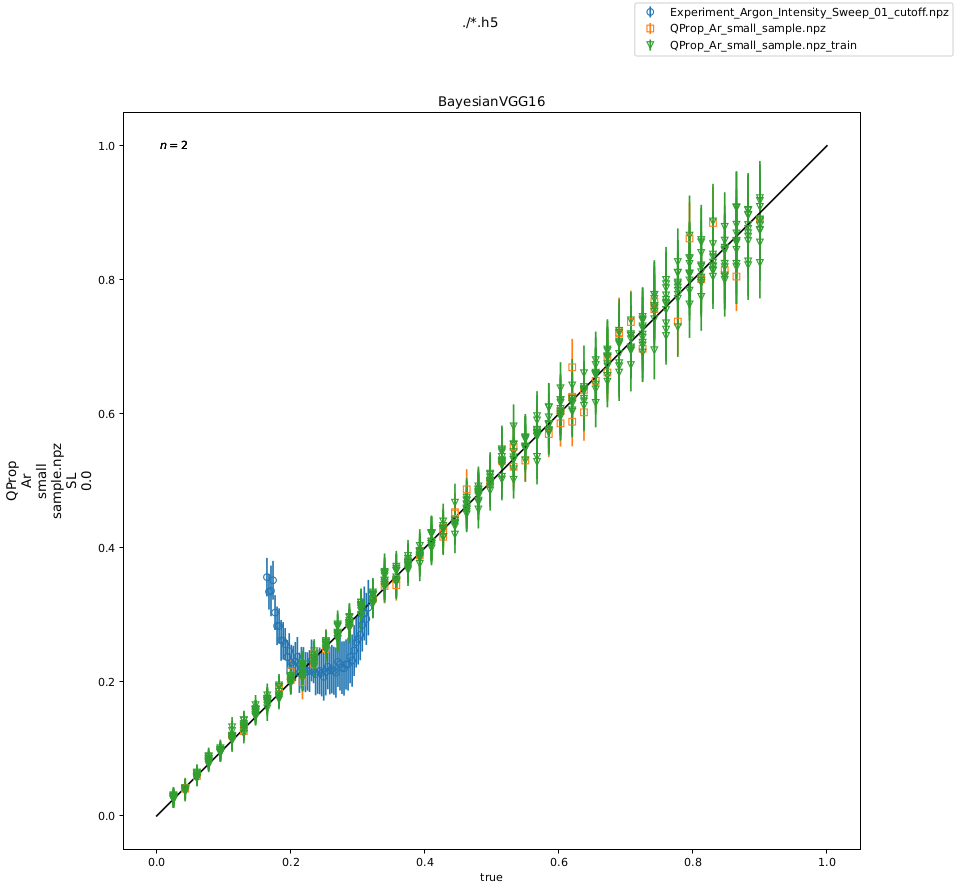

The plot above shows true vs predicted value of the ponderomotive potential on training, testing and experimental testing data.

File `analysis.pkl` with true vs predicted values and loss metrics may be further analyzed as in `03_evaluation_all_models.ipynb` notebook.

One can also load the saved model and datasets directly: 

In [46]:
import tensorflow as tf
from attoDNN.train_utils import RegressionNLL
from attoDNN.attodataset import AttoDataset
import attoDNN.preprocess as pp

from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# one model trained above is available online
# uncomment to download
#!wget --no-check-certificate https://chaos.if.uj.edu.pl/ZOA/tree//2303.13940/models/QProp_Ar_small_sample.npz_SL_0.0__BayesianVGG16__1000.h5'

In [26]:
model = tf.keras.models.load_model('QProp_Ar_small_sample.npz_SL_0.0__BayesianVGG16__1000.h5', compile=False)

In [28]:
model.compile(loss=RegressionNLL())

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.repeat (TFOpLambda)         (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['tf.repeat[0][0]']              
                                )                                                                 
                                                                                              

In [31]:
ds = AttoDataset('QProp_Ar_small_sample.npz')

In [35]:
feature = 'Up'

# preprocessing should ideally be the same as in training phase but changes by orders of magnitude here do not affects the results strongly
preprocess_kwargs = {
        'threshold': 1e-6,
        'downsample_1': 1,
        'downsample_2': 1,
        'shape': (224, 224, 1)
    }

def preprocessor(PDFs):
    return pp.preprocess_2(PDFs, **preprocess_kwargs) # see documentation how it preprocesses the data

In [36]:
ds.preprocess(preprocessor, feature)

In [37]:
X, y_true = ds.get_Xy()

In [39]:
X.shape, y_true.shape

((561, 224, 224, 1), (561, 1))

In [40]:
y_pred = model.predict(X, batch_size=8)

2023-04-06 17:48:28.631371: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-06 17:48:28.982029: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


71/71 [==============================] - 3s 17ms/step


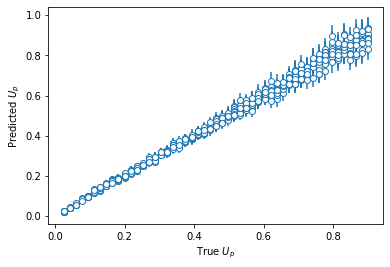

In [52]:
plt.errorbar(y_true[:,0], y_pred[:,0], yerr=np.sqrt(y_pred[:,1]), linestyle='none', marker='o', markerfacecolor='white')

plt.ylabel('Predicted $U_p$')
plt.xlabel('True $U_p$')
plt.show()

In [53]:
model.evaluate(X, y_true, batch_size=8) # negative log likelihood

71/71 [==============================] - 1s 14ms/step - loss: -3.4561


-3.4560744762420654